# PCA on Yale Face Dataset

This notebook demonstrates **Principal Component Analysis (PCA)** on the Yale Face Dataset.  
We will explore how images of faces can be represented using **eigenfaces**, compress images using a reduced number of principal components, and evaluate reconstruction quality.

📂 You can download the Yale Face Dataset from Kaggle:  
[https://www.kaggle.com/datasets/olgabelitskaya/yale-face-database](https://www.kaggle.com/datasets/olgabelitskaya/yale-face-database)


In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Constants
DATA_PATH = "data"
IMG_SIZE = (50, 50)
COMPONENTS_LIST = [25, 50, 100, 150]

---
## 1. Loading and Visualizing the Data

We load all grayscale face images, resize them to 50x50 pixels, and visualize a few examples.  
Each image is flattened into a vector for PCA.

In [2]:
def load_images(data_path, img_size=(50,50)):
    images, subjects, expressions = [], [], []
    files = sorted([f for f in os.listdir(data_path) if f.startswith("subject")])
    
    for fname in files:
        parts = fname.split(".")
        subject, expression = parts[0], parts[1]
        img = Image.open(os.path.join(data_path, fname)).convert("L")
        img = img.resize(img_size)
        images.append(np.array(img).flatten())
        subjects.append(subject)
        expressions.append(expression)
        
    return np.array(images), subjects, expressions

In [3]:
X, subjects, expressions = load_images(DATA_PATH, IMG_SIZE)

print("Data matrix shape:", X.shape)
print("Unique subjects:", len(set(subjects)))
print("Unique expressions:", set(expressions))

Data matrix shape: (165, 2500)
Unique subjects: 15
Unique expressions: {'centerlight', 'normal', 'sad', 'wink', 'happy', 'leftlight', 'noglasses', 'rightlight', 'surprised', 'sleepy', 'glasses'}


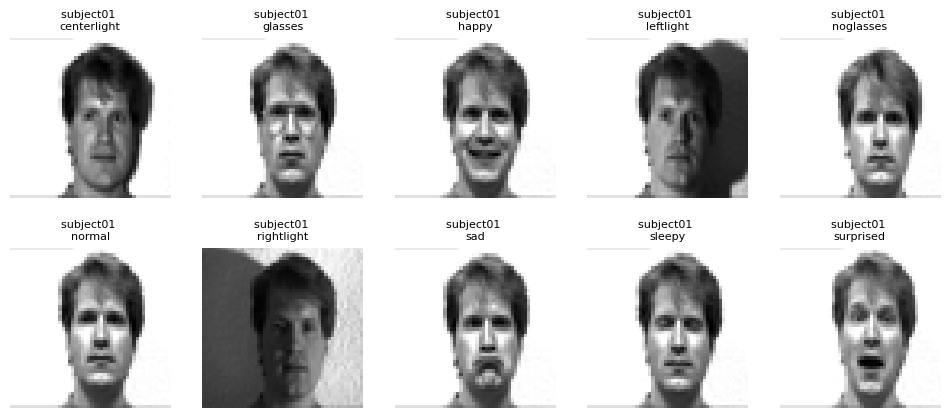

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(IMG_SIZE), cmap='gray')
    ax.set_title(f"{subjects[i]} \n{expressions[i]}", fontsize=8)
    ax.axis('off')
plt.show()

---
## 2. Data Preprocessing

We compute the **mean face** and center the data by subtracting it from each image.  
Centering ensures that PCA captures the directions of maximum variance in the data.

In [5]:
# Compute mean and std per pixel
mean_face = np.mean(X, axis=0)
std_face = np.std(X, axis=0)
std_face[std_face == 0] = 1  # avoid division by zero

# Standardize data
X_standardized = (X - mean_face) / std_face

---
## 3. PCA via SVD

We perform Singular Value Decomposition (SVD) on the centered data:

- `U` contains the left singular vectors (not used for reconstruction here)  
- `S` contains singular values  
- `Vt` contains the **eigenfaces** (principal components)  

Note: The maximum number of non-zero eigenfaces equals the number of images (165), because the data lives in a 165-dimensional subspace of the 2500-dimensional pixel space.

In [6]:
U, S, Vt = np.linalg.svd(X_standardized, full_matrices=False)
eigenfaces = Vt
print("Shape of eigenfaces:", eigenfaces.shape)

Shape of eigenfaces: (165, 2500)


---
## 4. Explained Variance

We compute the variance explained by each principal component.  
The cumulative variance plot shows how many components are needed to capture a desired percentage of the total variance.

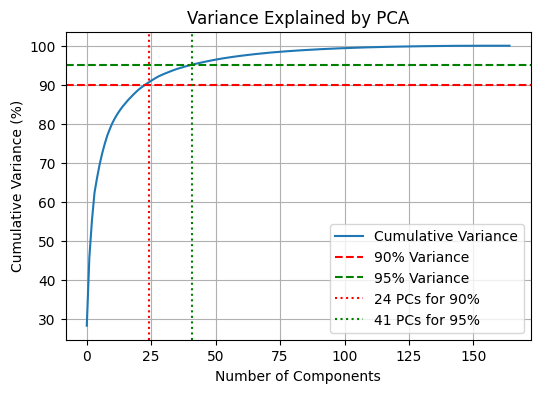

24 components explain 90% variance
41 components explain 95% variance


In [7]:
explained_variance = (S**2) / np.sum(S**2)
cumulative_variance = np.cumsum(explained_variance)

k_90 = np.argmax(cumulative_variance >= 0.90) + 1
k_95 = np.argmax(cumulative_variance >= 0.95) + 1

plt.figure(figsize=(6,4))
plt.plot(cumulative_variance*100, label="Cumulative Variance")
plt.axhline(y=90, color='r', linestyle='--', label="90% Variance")
plt.axhline(y=95, color='g', linestyle='--', label="95% Variance")
plt.axvline(x=k_90, color='r', linestyle=':', label=f"{k_90} PCs for 90%")
plt.axvline(x=k_95, color='g', linestyle=':', label=f"{k_95} PCs for 95%")

plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance (%)")
plt.title("Variance Explained by PCA")
plt.legend()
plt.grid(True)
plt.show()

print(f"{k_90} components explain 90% variance")
print(f"{k_95} components explain 95% variance")

---
## 5. Visualizing Mean Face and Eigenfaces

The mean face represents the average appearance of all images.  
Eigenfaces capture the most significant patterns of variation across faces.

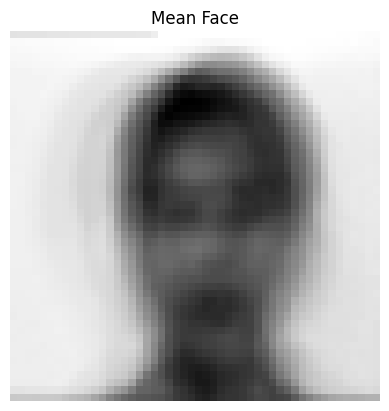

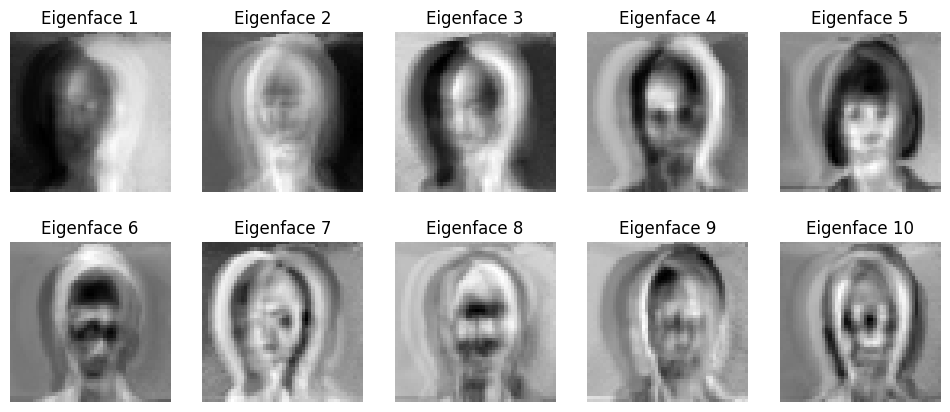

In [8]:
plt.imshow(mean_face.reshape(IMG_SIZE), cmap='gray')
plt.title("Mean Face")
plt.axis('off')
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(12,5))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i].reshape(IMG_SIZE), cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
    ax.axis('off')
plt.show()

---
## 6. Image Reconstruction

We reconstruct an example image using a reduced number of principal components to demonstrate compression.  
As the number of components increases, the reconstruction becomes more faithful.

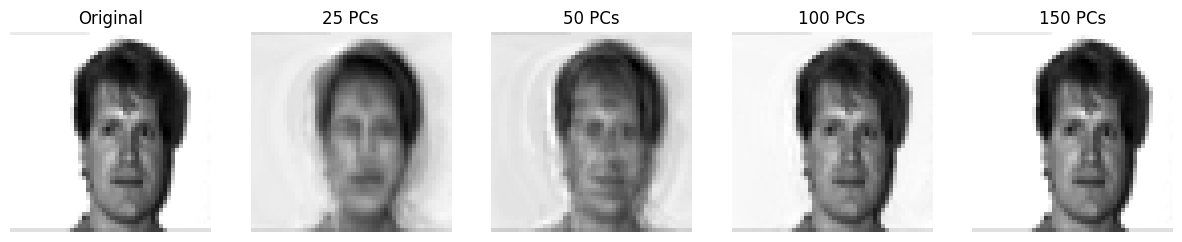

In [9]:
def reconstruct_face(img_vec, eigenfaces, mean_face, std_face, k):
    # Project onto top-k eigenfaces (using standardized data)
    proj = np.dot((img_vec - mean_face) / std_face, eigenfaces[:k].T)
    # Reconstruct and undo standardization
    recon = mean_face + np.dot(proj, eigenfaces[:k]) * std_face
    return recon

idx = 0
original = X[idx]

fig, axes = plt.subplots(1, 5, figsize=(15,4))
axes[0].imshow(original.reshape(IMG_SIZE), cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

for j, k in enumerate(COMPONENTS_LIST):
    recon = reconstruct_face(original, eigenfaces, mean_face, std_face, k)
    axes[j+1].imshow(recon.reshape(IMG_SIZE), cmap='gray')
    axes[j+1].set_title(f"{k} PCs")
    axes[j+1].axis('off')
plt.show()

---
## 7. Compression Ratio and Reconstruction Error

We compute the storage requirement for each compression level and evaluate reconstruction quality using Mean Squared Error (MSE).  
This quantifies the trade-off between compression and fidelity.

In [10]:
original_size = X.shape[1]

for k in COMPONENTS_LIST:
    compressed_size = k
    compression_ratio = compressed_size / original_size
    print(f"{k} components: store {compressed_size} vs {original_size} → "
          f"{compression_ratio:.2%} of original size")

print("\n" + "-"*50 + "\n")

for k in COMPONENTS_LIST:
    recon = reconstruct_face(original, eigenfaces, mean_face, std_face, k)
    mse = mean_squared_error(original, recon)
    print(f"Reconstruction with {k} PCs → MSE: {mse:.2f}")

25 components: store 25 vs 2500 → 1.00% of original size
50 components: store 50 vs 2500 → 2.00% of original size
100 components: store 100 vs 2500 → 4.00% of original size
150 components: store 150 vs 2500 → 6.00% of original size

--------------------------------------------------

Reconstruction with 25 PCs → MSE: 726.09
Reconstruction with 50 PCs → MSE: 315.55
Reconstruction with 100 PCs → MSE: 13.72
Reconstruction with 150 PCs → MSE: 0.00


---
## 8. Observations

- A small number of components (25–50) already capture coarse facial structure.  
- Higher components (100–150) refine details like eyes and mouth.  
- The cumulative variance plot indicates how many PCs are needed for a given percentage of variance (e.g., 95%).  
- Eigenfaces corresponding to smaller singular values mostly encode noise.